$$
\def\CC{\bf C}
\def\QQ{\bf Q}
\def\RR{\bf R}
\def\ZZ{\bf Z}
\def\NN{\bf N}
$$

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Handle motion/drift with spikeinterface

Spikeinterface offers a very flexible framework to handle drift as a
preprocessing step. If you want to know more, please read the
[motion_correction](motion_correction.ipynb) section of the
documentation.

Here is a short demo on how to handle drift using the high-level
function :py`~spikeinterface.preprocessing.correct_motion()`.

This function takes a preprocessed recording as input and then
internally runs several steps (it can be slow!) and returns a lazy
recording that interpolates the traces on-the-fly to compensate for the
motion.

Internally this function runs the following steps:

In [ ]:
1. localize_peaks()
2. select_peaks() (optional)
3. estimate_motion()
4. interpolate_motion()

All these sub-steps can be run with different methods and have many
parameters.

The high-level function suggests 3 predifined “presets” and we will
explore them using a very well known public dataset recorded by Nick
Steinmetz: [Imposed motion
datasets](https://figshare.com/articles/dataset/_Imposed_motion_datasets_from_Steinmetz_et_al_Science_2021/14024495)

This dataset contains 3 recordings and each recording contains a
Neuropixels 1 and a Neuropixels 2 probe.

Here we will use *dataset1* with *neuropixel1*. This dataset is the
*“hello world”* for drift correction in the spike sorting community!

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

import shutil

import spikeinterface.full as si

In [3]:
base_folder = Path('/home/pierre/data/sorting/nick')
dataset_folder = base_folder / 'dataset1/NP1'

In [4]:
# read the file
raw_rec = si.read_spikeglx(dataset_folder)
raw_rec

SpikeGLXRecordingExtractor: 384 channels - 30.0kHz - 1 segments - 58,715,724 samples 
                            1,957.19s (32.62 minutes) - int16 dtype - 42.00 GiB

SpikeGLXRecordingExtractor: 384 channels - 30.0kHz - 1 segments - 58,715,724 samples  
1,957.19s (32.62 minutes) - int16 dtype - 42.00 GiB

We preprocess the recording with bandpass filter and a common median
reference. Note, that it is better to not whiten the recording before
motion estimation to get a better estimate of peak locations!

In [5]:
def preprocess_chain(rec):
    rec = si.bandpass_filter(rec, freq_min=300., freq_max=6000.)
    rec = si.common_reference(rec, reference='global', operator='median')
    return rec
rec = preprocess_chain(raw_rec)

In [6]:
job_kwargs = dict(n_jobs=-1, chunk_duration='1s', progress_bar=True)

## Run motion correction with one function!

Correcting for drift is easy! You just need to run a single function. We
will try this function with 3 presets.

Internally a preset is a dictionary of dictionaries containing all
parameters for every steps.

Here we also save the motion correction results into a folder to be able
to load them later.

In [7]:
# internally, we can explore a preset like this
# every parameter can be overwritten at runtime
from spikeinterface.preprocessing.motion import motion_options_preset
motion_options_preset['kilosort_like']

{'doc': 'Mimic the drift correction of kilosrt (grid_convolution + iterative_template)',
 'detect_kwargs': {'method': 'locally_exclusive',
  'peak_sign': 'neg',
  'detect_threshold': 8.0,
  'exclude_sweep_ms': 0.1,
  'local_radius_um': 50},
 'select_kwargs': None,
 'localize_peaks_kwargs': {'method': 'center_of_mass',
  'feature': 'noise_free_energy'},
 'estimate_motion_kwargs': {'method': 'iterative_template',
  'bin_duration_s': 2.0,
  'rigid': False,
  'win_step_um': 50.0,
  'win_sigma_um': 150.0,
  'margin_um': 0,
  'win_shape': 'rect'},
 'interpolate_motion_kwargs': {'direction': 1,
  'border_mode': 'force_extrapolate',
  'spatial_interpolation_method': 'kriging',
  'sigma_um': [20.0, 30],
  'p': 1}}

{'doc': 'Mimic the drift correction of kilosrt (grid_convolution + iterative_template)',  
'detect_kwargs': {'method': 'locally_exclusive',  
'peak_sign': 'neg', 'detect_threshold': 8.0, 'exclude_sweep_ms': 0.1,
'local_radius_um': 50},

'select_kwargs': None, 'localize_peaks_kwargs': {'method':
'grid_convolution', 'local_radius_um': 30.0, 'upsampling_um': 3.0,
'sigma_um': array(\[ 5. , 12.5, 20. \]), 'sigma_ms': 0.25, 'margin_um':
30.0, 'prototype': None, 'percentile': 5.0}, 'estimate_motion_kwargs':
{'method': 'iterative_template', 'bin_duration_s': 2.0, 'rigid': False,
'win_step_um': 50.0, 'win_sigma_um': 150.0, 'margin_um': 0, 'win_shape':
'rect'}, 'interpolate_motion_kwargs': {'direction': 1, 'border_mode':
'force_extrapolate', 'spatial_interpolation_method': 'kriging',
'sigma_um': \[20.0, 30\], 'p': 1}}

In [8]:
# lets try theses 3 presets
#some_presets = ('rigid_fast',  'kilosort_like', 'nonrigid_accurate')
some_presets = ('kilosort_like', )
# some_presets = ('nonrigid_accurate',  )

In [9]:
# compute motion with 3 presets
for preset in some_presets:
    print('Computing with', preset)
    folder = base_folder / 'motion_folder_dataset1' / preset
    if folder.exists():
        shutil.rmtree(folder)
    recording_corrected, motion_info = si.correct_motion(rec, preset=preset,
                                                         folder=folder,
                                                         output_motion_info=True, **job_kwargs)

Computing with kilosort_like


/home/pierre/github/spikeinterface/src/spikeinterface/sortingcomponents/peak_detection.py:643: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(parallel=False)
/home/pierre/github/spikeinterface/src/spikeinterface/sortingcomponents/peak_detection.py:668: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(parallel=False)


detect and localize:   0%|          | 0/1958 [00:00<?, ?it/s]

## Plot the results

We load back the results and use the widgets module to explore the
estimated drift motion.

For all methods we have 4 plots:

> -   top left: time vs estimated peak depth
> -   top right: time vs peak depth after motion correction
> -   bottom left: the average motion vector across depths and all
>     motion across spatial depths (for non-rigid estimation)
> -   bottom right: if motion correction is non rigid, the motion vector
>     across depths is plotted as a map, with the color code
>     representing the motion in micrometers.

A few comments on the figures:  
-   the preset **‘rigid_fast’** has only one motion vector for the
    entire probe because it is a “rigid” case. The motion amplitude is
    globally underestimated because it averages across depths. However,
    the corrected peaks are flatter than the non-corrected ones, so the
    job is partially done. The big jump at=600s when the probe start
    moving is recovered quite well.
-   The preset **kilosort_like** gives better results because it is a
    non-rigid case. The motion vector is computed for different depths.
    The corrected peak locations are flatter than the rigid case. The
    motion vector map is still be a bit noisy at some depths (e.g around
    1000um).
-   The preset **nonrigid_accurate** seems to give the best results on
    this recording. The motion vector seems less noisy globally, but it
    is not “perfect” (see at the top of the probe 3200um to 3800um).
    Also note that in the first part of the recording before the imposed
    motion (0-600s) we clearly have a non-rigid motion: the upper part
    of the probe (2000-3000um) experience some drifts, but the lower
    part (0-1000um) is relatively stable. The method defined by this
    preset is able to capture this.

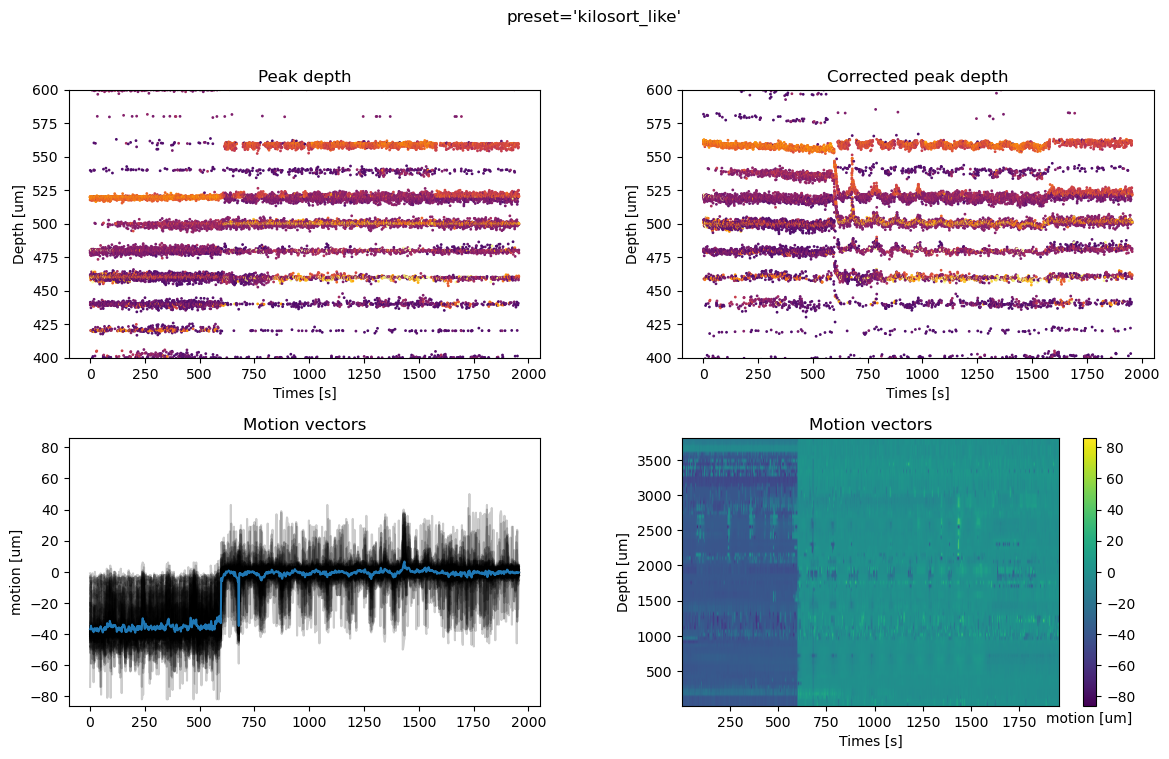

In [10]:
for preset in some_presets:
    # load
    folder = base_folder / 'motion_folder_dataset1' / preset
    motion_info = si.load_motion_info(folder)

    # and plot
    fig = plt.figure(figsize=(14, 8))
    si.plot_motion(rec, motion_info, figure=fig, depth_lim=(400, 600),
                   color_amplitude=True, amplitude_cmap='inferno',  scatter_decimate=10)
    fig.suptitle(f"{preset=}")

![image](handle_drift_files/handle_drift_13_0.png)

![image](handle_drift_files/handle_drift_13_1.png)

![image](handle_drift_files/handle_drift_13_2.png)

## Plot peak localization

We can also use the internal extra results (peaks and peaks location) to
check if putative clusters have a lower spatial spread after the motion
correction.

Here we plot the estimated peak locations (left) and the corrected peak
locations (on right) on top of the probe. The color codes for the peak
amplitudes.

We can see here that some clusters seem to be more compact on the ‘y’
axis, especially for the preset “nonrigid_accurate”.

Be aware that there are two ways to correct for the motion: 1.
Interpolate traces and detect/localize peaks again
(:py`interpolate_recording()`) 2. Compensate for drifts directly on peak
locations (:py`correct_motion_on_peaks()`)

Case 1 is used before running a spike sorter and the case 2 is used here
to display the results.

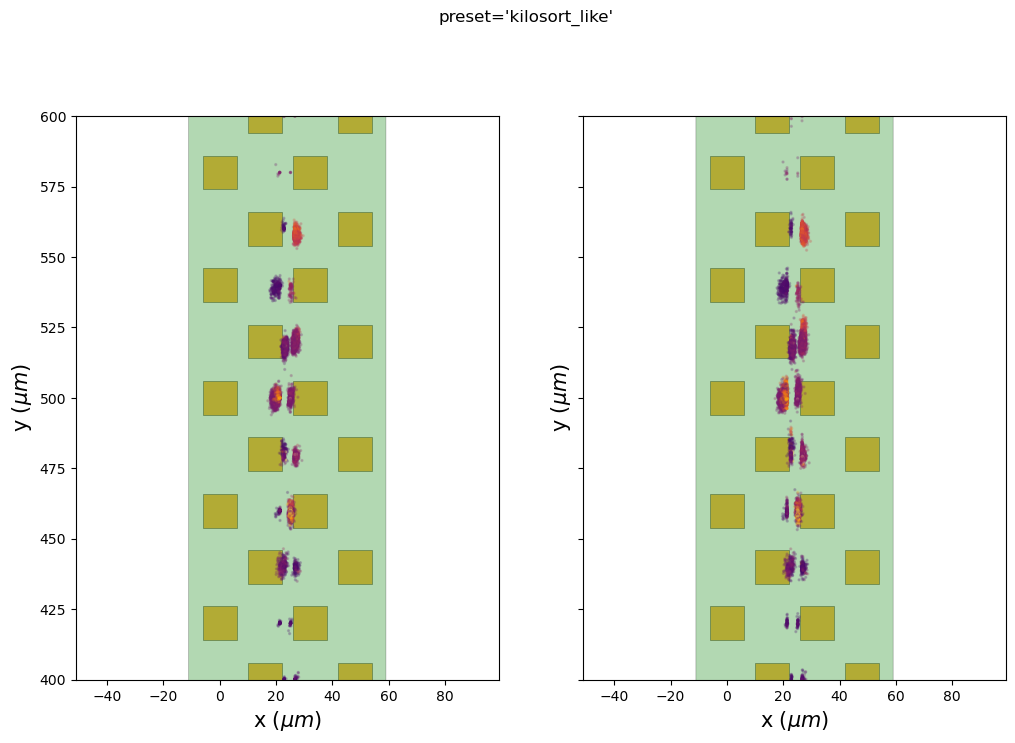

In [11]:
from spikeinterface.sortingcomponents.motion_interpolation import correct_motion_on_peaks

for preset in some_presets:
    folder = base_folder / 'motion_folder_dataset1' / preset
    motion_info = si.load_motion_info(folder)

    fig, axs = plt.subplots(ncols=2, figsize=(12, 8), sharey=True)

    ax = axs[0]
    si.plot_probe_map(rec, ax=ax)

    peaks = motion_info['peaks']
    sr = rec.get_sampling_frequency()
    time_lim0 = 750.
    time_lim1 = 1500.
    mask = (peaks['sample_index'] > int(sr * time_lim0)) & (peaks['sample_index'] < int(sr * time_lim1))
    sl = slice(None, None, 5)
    amps = np.abs(peaks['amplitude'][mask][sl])
    amps /= np.quantile(amps, 0.95)
    c = plt.get_cmap('inferno')(amps)

    color_kargs = dict(alpha=0.2, s=2, c=c)

    loc = motion_info['peak_locations']
    #color='black',
    ax.scatter(loc['x'][mask][sl], loc['y'][mask][sl], **color_kargs)

    loc2 = correct_motion_on_peaks(motion_info['peaks'], motion_info['peak_locations'], rec.get_times(),
                                   motion_info['motion'], motion_info['temporal_bins'], motion_info['spatial_bins'], direction="y")

    ax = axs[1]
    si.plot_probe_map(rec, ax=ax)
    #  color='black',
    ax.scatter(loc2['x'][mask][sl], loc2['y'][mask][sl], **color_kargs)

    ax.set_ylim(400, 600)
    fig.suptitle(f"{preset=}")

![image](handle_drift_files/handle_drift_15_0.png)

![image](handle_drift_files/handle_drift_15_1.png)

![image](handle_drift_files/handle_drift_15_2.png)

### run times

Presets and related methods have differents accuracies but also
computation speeds. It is good to have this in mind!

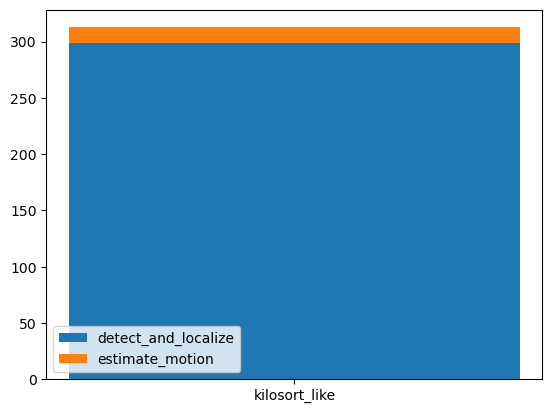

In [18]:
run_times = []
for preset in some_presets:
    folder = base_folder / 'motion_folder_dataset1' / preset
    motion_info = si.load_motion_info(folder)
    run_times.append(motion_info['run_times'])
keys = run_times[0].keys()

bottom = np.zeros(len(run_times))
fig, ax = plt.subplots()
for k in keys:
    rtimes = np.array([rt[k] for rt in run_times])
    if np.any(rtimes>0.):
        ax.bar(some_presets, rtimes, bottom=bottom, label=k)
    bottom += rtimes
ax.legend()

\<matplotlib.legend.Legend at 0x7f0178a0ada0\>

![image](handle_drift_files/handle_drift_17_1.png)